In [1]:
import pandas as pd
import numpy as np
import os
from copy import copy
from tqdm import tqdm
from glob import glob
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras

from rdkit.Chem import MolStandardize, MolFromSmiles, MolToSmiles

from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


2022-11-27 19:08:19.919398: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-27 19:08:20.180281: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
with open("../data/raw/dataset_sampled.smi") as f:
    smiles = [s.split("\t")[0].rstrip() for s in f]
smiles[:4]


['C1CCCCCNc2cc[n+](Cc3cccc(c3)c4cccc(C[n+]5ccc(NCCCC1)c6ccccc56)c4)c7ccccc27',
 'Br\\C=C\\1/CCC(C(=O)O1)c2cccc3ccccc23',
 'I\\C=C\\1/CCC(C(=O)O1)c2cccc3ccccc23',
 'O=C1O\\C(=C\\C#C)\\CCC1c2cccc3ccccc23']

In [3]:
class SmilesTokenizer(object):
    def __init__(self):
        atoms = [
            "Al",
            "As",
            "B",
            "Br",
            "C",
            "Cl",
            "F",
            "H",
            "I",
            "K",
            "Li",
            "N",
            "Na",
            "O",
            "P",
            "S",
            "Se",
            "Si",
            "Te",
        ]
        special = [
            "(",
            ")",
            "[",
            "]",
            "=",
            "#",
            "%",
            "0",
            "1",
            "2",
            "3",
            "4",
            "5",
            "6",
            "7",
            "8",
            "9",
            "+",
            "-",
            "se",
            "te",
            "c",
            "n",
            "o",
            "s",
        ]
        padding = ["G", "A", "E"]

        self.table = sorted(atoms, key=len, reverse=True) + special + padding
        table_len = len(self.table)

        self.table_2_chars = list(filter(lambda x: len(x) == 2, self.table))
        self.table_1_chars = list(filter(lambda x: len(x) == 1, self.table))

        self.one_hot_dict = {}
        for i, symbol in enumerate(self.table):
            vec = np.zeros(table_len, dtype=np.float32)
            vec[i] = 1
            self.one_hot_dict[symbol] = vec

    def tokenize(self, smiles):
        smiles = smiles + " "
        N = len(smiles)
        token = []
        i = 0
        while i < N:
            c1 = smiles[i]
            c2 = smiles[i : i + 2]

            if c2 in self.table_2_chars:
                token.append(c2)
                i += 2
                continue

            if c1 in self.table_1_chars:
                token.append(c1)
                i += 1
                continue

            i += 1

        return token

    def one_hot_encode(self, tokenized_smiles):
        result = np.array(
            [self.one_hot_dict[symbol] for symbol in tokenized_smiles], dtype=np.float32
        )
        result = result.reshape(1, result.shape[0], result.shape[1])
        return result


In [4]:
class Preprocessor(object):
    def __init__(self):
        self.normarizer = MolStandardize.normalize.Normalizer()
        self.lfc = MolStandardize.fragment.LargestFragmentChooser()
        self.uc = MolStandardize.charge.Uncharger()

    def process(self, smi):
        mol = MolFromSmiles(smi)
        if mol:
            mol = self.normarizer.normalize(mol)
            mol = self.lfc.choose(mol)
            mol = self.uc.uncharge(mol)
            smi = MolToSmiles(mol, isomericSmiles=False, canonical=True)
            return smi
        else:
            return None


In [5]:
pp = Preprocessor()

print(f"input SMILES num: {len(smiles)}")
print("start preprocessing...")

smiles = [pp.process(smi) for smi in tqdm(smiles)]
smiles = list(set([s for s in smiles if s]))

# token limits (34 to 74)
st = SmilesTokenizer()
smiles_tokenized = [st.tokenize(smi) for smi in tqdm(smiles)]
smiles_processed = []
smiles_max_len = 0


# check for not recognized tokens
err = 0
err_tokens = []
for i in range(len(smiles)):
    if smiles[i] != "".join(smiles_tokenized[i]):
        print("=====================================")
        print(len(smiles[i]), " :", smiles[i])
        print(len(smiles_tokenized[i]), " :" ,smiles_tokenized[i])
        for char in smiles[i]:
            if char not in smiles_tokenized[i]:
                err_tokens.append(char)
        err += 1
print("Error: ", err)
print("Error Tokens: ", err_tokens)


for tokenized in smiles_tokenized:
    if 34 <= len(tokenized) <= 74:
        smiles_processed.append(tokenized)
        # update smiles max len
        if len(tokenized) > smiles_max_len:
            smiles_max_len = len(tokenized)

print(f"Max SMILES length: {smiles_max_len}")
print(f"output SMILES num: {len(smiles_processed)}")


input SMILES num: 1000
start preprocessing...


100%|██████████| 976/976 [00:00<00:00, 54722.70it/s]

Error:  0
Error Tokens:  []
Max SMILES length: 74
output SMILES num: 582


In [6]:
def _pad(tokenized_smi):
    return (
        ["G"] + tokenized_smi + ["E"] + ["A" for _ in range(smiles_max_len - len(tokenized_smi))]
    )

def _padding(data):
    padded_smiles = [_pad(t_smi) for t_smi in data]
    return padded_smiles


In [7]:
# add paddings
print("".join(smiles_processed[0]))
smiles_processed = _padding(smiles_processed)
print("".join(smiles_processed[0]))


Cc1ccc(Sc2cncc3sc(C(N)=O)cc23)c(C)c1
GCc1ccc(Sc2cncc3sc(C(N)=O)cc23)c(C)c1EAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA


In [8]:
# one hot encode
x, y = [], []

for tp_smi in smiles_processed[:5]:
    print("-----------------------------------")
    print("".join(tp_smi[:-1]))
    print("".join(tp_smi[1:]))

for tp_smi in smiles_processed:
    _x = [st.one_hot_dict[symbol] for symbol in tp_smi[:-1]]
    x.append(_x)
    _y = [st.one_hot_dict[symbol] for symbol in tp_smi[1:]]
    y.append(_y)

x = np.array(x, dtype=np.float32)
y = np.array(y, dtype=np.float32)
print(x.shape)
x


-----------------------------------
GCc1ccc(Sc2cncc3sc(C(N)=O)cc23)c(C)c1EAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
Cc1ccc(Sc2cncc3sc(C(N)=O)cc23)c(C)c1EAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
-----------------------------------
GCOc1ccc2c(c1)-c1nc(-c3ccncc3)[nH]c1CCC2EAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
COc1ccc2c(c1)-c1nc(-c3ccncc3)[nH]c1CCC2EAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
-----------------------------------
GCn1cc(C2=C(c3cn(CCCCCO)c4ccccc34)C(=O)NC2=O)c2ccccc21EAAAAAAAAAAAAAAAAAAAA
Cn1cc(C2=C(c3cn(CCCCCO)c4ccccc34)C(=O)NC2=O)c2ccccc21EAAAAAAAAAAAAAAAAAAAAA
-----------------------------------
GNc1nc(N)c2cc(S(=O)(=O)c3ccc4ccccc4c3)ccc2n1EAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
Nc1nc(N)c2cc(S(=O)(=O)c3ccc4ccccc4c3)ccc2n1EAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
-----------------------------------
GNc1cc[n+](Cc2ccc(Cc3ccc(C[n+]4ccc(N)c5ccccc54)cc3)cc2)c2ccccc12EAAAAAAAAAA
Nc1cc[n+](Cc2ccc(Cc3ccc(C[n+]4ccc(N)c5ccccc54)cc3)cc2)c2ccccc12EAAAAAAAAAAA
(582, 75, 47)


array([[[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.]],

       [[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.]],

       [[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.]],

       ...,

       [[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1.

In [9]:
# split data to 10% test, 20% validation, 70% train
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
y_test


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1.

In [10]:
for i in range(x.shape[0]):
    if x[i].shape != y[i].shape:
        print(x[i].shape)
        print(y[i].shape)


In [11]:
# model

np.set_printoptions(precision=3, suppress=True)
tfd = tfp.distributions


class CustomizedLayer_Polarizer(keras.layers.Layer):
    def __init__(self, units=32):
        super(CustomizedLayer_Polarizer, self).__init__()

    def call(self, inputs):
        G_thesis = inputs
        G_antithesis = 1 - inputs

        return [G_thesis, G_antithesis]


class CustomizedLayer_Attention(keras.layers.Layer):
    def __init__(self, units=32):
        super(CustomizedLayer_Attention, self).__init__()

    def call(self, inputs):
        # G_LSTM= inputs[:,:60]
        # G_Attention= inputs[:,60:]
        # res= tf.math.add(G_LSTM, G_Attention)
        elem_prod = inputs[:, :, :60] + inputs[:, :, 60:]
        # res = k.sum(elem_prod, axis=-1, keepdims=True)
        return elem_prod


def prior_mean_field(kernel_size, bias_size, dtype=None):  # prior Function
    n = kernel_size + bias_size
    return lambda t: tfd.Independent(
        tfd.Normal(loc=tf.zeros(n, dtype=dtype), scale=tf.ones(n)), reinterpreted_batch_ndims=1
    )


def posterior_mean_field(kernel_size, bias_size=0, dtype=None):  # Posterior Function
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.0))
    return tf.keras.Sequential(
        [
            tfp.layers.VariableLayer(2 * n, dtype=dtype),
            tfp.layers.DistributionLambda(
                lambda t: tfd.Independent(
                    tfd.Normal(loc=t[..., :n], scale=1e-5 + 0.01 * tf.nn.softplus(c + t[..., n:])),
                    reinterpreted_batch_ndims=1,
                )
            ),
        ]
    )


data_len = x.shape[0]
hidden_units = [70, 70, 70]
batch_size = 50
counter_L = 0
look_back = 1
model = Sequential()
# InData_Ex1 = layers.Input(shape=([1, 70]), name="Input_Ex1")
# InData_Ex2 = layers.Input(shape=([1, 70]), name="polarizer")
# InData_Ex3 = layers.Input(shape=([1, 70]), name="Input_EX3")
InData_Ex1 = layers.Input(shape=([(smiles_max_len + 1), 47]), name="Input_Ex1")
InData_Ex2 = layers.Input(shape=([(smiles_max_len + 1), 47]), name="polarizer")
InData_Ex3 = layers.Input(shape=([(smiles_max_len + 1), 47]), name="Input_EX3")
EX_lstm1 = layers.LSTM(60, return_sequences=True)(InData_Ex1)
EX_lstm2 = layers.LSTM(60, return_sequences=True)(InData_Ex2)
GateIn = layers.Dense(units=60, activation="sigmoid")(InData_Ex3)
Gate_pp = layers.Dense(units=60, activation="sigmoid")(GateIn)
Gate_pp = layers.Dense(units=60, activation="sigmoid")(Gate_pp)
CFPG = CustomizedLayer_Polarizer(units=60)(Gate_pp)
# GatesODD = layers.Dense(units=60, activation='sigmoid')(GatesIn)
MultiplictionEven_In = layers.Concatenate(axis=-1)([EX_lstm1, CFPG[0]])
MultiplictionEven_In = CustomizedLayer_Attention()(MultiplictionEven_In)
EX_lstm1 = layers.LSTM(60, return_sequences=True)(MultiplictionEven_In)
MultiplictionEven = layers.Dense(units=35, activation="sigmoid")(EX_lstm1)
MultiplictionODD_In = layers.Concatenate(axis=-1)([EX_lstm2, CFPG[1]])
MultiplictionODD_In = CustomizedLayer_Attention()(MultiplictionODD_In)
EX_lstm2 = layers.LSTM(60, return_sequences=True)(MultiplictionODD_In)
MultiplictionODD = layers.Dense(units=35, activation="sigmoid")(EX_lstm2)
# features = layers.Concatenate([InData_Ex1, InData_Ex2, InData_Ex3, InData_Ex4])
InData = layers.Concatenate(axis=-1)([MultiplictionEven, MultiplictionODD])
InData = layers.BatchNormalization()(InData)
features = InData
for units in hidden_units:
    features = tfp.layers.DenseVariational(
        units=units,
        make_prior_fn=prior_mean_field,
        make_posterior_fn=posterior_mean_field,
        kl_weight=1 / data_len,
        activation="relu",
    )(features)
# features = layers.Dense(units=70, activation="sigmoid")(features)
features = layers.Dense(units=47, activation="sigmoid")(features)
model = keras.Model(inputs=[InData_Ex1, InData_Ex2, InData_Ex3], outputs=features)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.summary()


2022-11-27 19:08:23.618113: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_EX3 (InputLayer)         [(None, 75, 47)]     0           []                               
                                                                                                  
 dense (Dense)                  (None, 75, 60)       2880        ['Input_EX3[0][0]']              
                                                                                                  
 dense_1 (Dense)                (None, 75, 60)       3660        ['dense[0][0]']                  
                                                                                                  
 Input_Ex1 (InputLayer)         [(None, 75, 47)]     0           []                               
                                                                                              

In [12]:
callbacks = []
callbacks.append(
    ModelCheckpoint(
        filepath=os.path.join(
            "../reports/",
            "2022-11-26",
            "test",
            "checkpoints",
            '{epoch:02d}.hdf5'),
        monitor="val_loss",
        mode="min",
        save_best_only=False,
        save_weights_only=True,
        verbose=True,
    )
)
# create checkpoints dir
os.makedirs(os.path.join(
    "../reports/",
    "2022-11-26",
    "test",
    "checkpoints"), exist_ok=True)

callbacks.append(
    TensorBoard(
        log_dir=os.path.join(
            "../reports/",
            "2022-11-26",
            "test",
            "logs",
        ),
        write_graph=True,
        write_images=True,
        update_freq="epoch",
    )
)


In [13]:
history = model.fit(
            {"Input_Ex1": x_train, "polarizer": x_train, "Input_EX3": x_train},
            y_train,
            # steps_per_epoch=x_train.shape[0],
            epochs=1,
            verbose=True,
            validation_data=({"Input_Ex1": x_val, "polarizer": x_val, "Input_EX3": x_val}, y_val),
            # validation_steps=x_val.shape[0],
            # validation_steps=30,
            use_multiprocessing=True,
            shuffle=True,
            callbacks=callbacks,
        )

# last_weight_file = glob(
#     os.path.join(
#         "../reports/",
#         "2022-11-15",
#         "test",
#         "checkpoints",
#         'test-{30:02}*.hdf5')
# )[0]


Layer CustomizedLayer_Polarizer has arguments ['units']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config
13/14 [==========================>...] - ETA: 0s - loss: 105.6842 - accuracy: 0.0054
Epoch 1: saving model to ../reports/2022-11-26/test/checkpoints/01.hdf5
14/14 [==============================] - 6s 125ms/step - loss: 105.6850 - accuracy: 0.0054 - val_loss: 105.6203 - val_accuracy: 0.0154


In [14]:
# predict 5 new smiles
y_pred = model.predict(
    {"Input_Ex1": x_test, "polarizer": x_test, "Input_EX3": x_test},
    verbose=True,
    use_multiprocessing=True,
)


2/2 [==============================] - 1s 18ms/step


In [15]:
import random

def decode_smiles(x):
    keys = list(st.one_hot_dict.keys())
    tmp = [keys[np.argmax(i)] for i in x]
    return("".join(tmp))

y_test_copy = y_test.copy()
y_test_decoded = []
# y_test_copy to smiles
for encoded_smi in y_test_copy:
    smi = decode_smiles(encoded_smi)
    y_test_decoded.append(smi)

y_pred_copy = y_pred.copy()
# TODO: delete this
# pick random samples of y_train with len y_pred_copy
y_pred_copy = random.sample(list(y_train), len(y_pred_copy))

y_pred_decoded = []
# y_pred_copy to smiles
for encoded_smi in y_pred_copy:
    smi = decode_smiles(encoded_smi)
    y_pred_decoded.append(smi)

# Remove G, E, A paddings
y_test_decoded = [smi.replace("G", "").replace("E", "").replace("A", "") for smi in y_test_decoded]
y_pred_decoded = [smi.replace("G", "").replace("E", "").replace("A", "") for smi in y_pred_decoded]

# compare y_test_decoded and y_pred_decoded
for i in range(5):
    print("y_test_decoded: ", y_test_decoded[i])
    print("y_pred_decoded: ", y_pred_decoded[i])
    print("")


y_test_decoded:  CCCCNC(=O)C1CCN(c2nc(N)c3cc(OC)c(OC)cc3n2)CC1
y_pred_decoded:  COc1cc2nc(N3CCN(C(S)=Nc4ccc(N=[N+]=[N-])cc4)CC3)nc(N)c2cc1OC

y_test_decoded:  COc1cc2nc(N3CCN(C(=O)C4CC4c4ccccc4)CC3)nc(N)c2cc1OC
y_pred_decoded:  Cn1cc(C2=C(c3cn(CCO)c4ccccc34)C(=O)NC2=O)c2ccccc21

y_test_decoded:  CCCCC(=CCn1oc(=O)[nH]c1=O)c1cccc(OCc2cc(Cl)cc(Cl)c2)c1
y_pred_decoded:  Clc1ccc(N2CCN(Cc3cnn4ccccc34)CC2)cc1

y_test_decoded:  COc1ccc(NC(=O)NC(CCSC)C(=O)NC(CC(C)C)C(=O)NC(Cc2ccccc2)C(=O)O)cc1
y_pred_decoded:  CCCCc1nc(C(=O)OCC)c(C(=O)OCC)n1Cc1ccc(-c2ccccc2-c2nn[nH]n2)cc1

y_test_decoded:  COc1cc2nc(N3CCN(C(=O)C4OC4c4ccccc4)CC3)nc(N)c2cc1OC
y_pred_decoded:  CN1Cc2c(C(=O)OC(C)(C)C)ncn2-c2ccc(N=[N+]=[N-])cc2C1=O



In [16]:
from rdkit import  Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors


pred_mols = []
for smi in y_pred_decoded:
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        pred_mols.append(mol)
# low validity
print(f'{len(pred_mols) / 30000:.2%}')

pred_mols_2 = [Chem.MolToSmiles(mol) for mol in pred_mols]
# high uniqueness
print(f'{len(set(pred_mols_2)) / len(pred_mols_2):.2%}')

org_mols = [mol for mol in [Chem.MolFromSmiles(smi) for smi in y_test_decoded] if mol is not None]



0.20%
100.00%


In [17]:
Vfps = []
for mol in pred_mols:
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Vfps.append(fp)

Ofps = []
for mol in org_mols:
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Ofps.append(fp)

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
Vlen = len(Vfps)
x = Vfps + Ofps
x = pca.fit_transform(x)
x

array([[-0.678, -2.591],
       [-1.222,  0.101],
       [-0.381, -0.735],
       [-0.249, -0.661],
       [ 0.366, -1.29 ],
       [-1.261, -0.261],
       [ 2.376, -0.965],
       [-1.634,  1.893],
       [ 0.148,  0.136],
       [ 0.111, -1.038],
       [-1.043,  3.638],
       [-0.991,  0.248],
       [-1.873, -2.172],
       [-0.234,  1.096],
       [ 0.237,  0.807],
       [-1.843, -2.391],
       [ 3.11 ,  0.179],
       [ 0.126,  1.185],
       [ 3.731, -1.502],
       [ 4.14 , -0.68 ],
       [ 0.846,  0.656],
       [-0.551, -1.046],
       [-1.796,  2.331],
       [-0.328, -0.953],
       [-1.455,  0.101],
       [-0.724,  2.681],
       [-1.873, -2.296],
       [-0.889,  1.622],
       [-1.414,  1.372],
       [-1.315, -0.374],
       [-1.677, -2.36 ],
       [ 1.327,  0.434],
       [-2.13 ,  0.372],
       [ 4.256, -1.053],
       [-0.679,  2.204],
       [ 0.516, -0.151],
       [-0.233, -0.717],
       [ 0.169,  2.501],
       [-0.438, -0.657],
       [-0.517, -0.766],


In [19]:
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt


# plt.figure(figsize=(12, 9))
# plt.scatter(x[Vlen:, 0], x[Vlen:, 1], c='w', edgecolors='k', label='original')
# plt.scatter(x[:Vlen, 0], x[:Vlen, 1], marker='+', label='generated')
# plt.xlabel('PC 1')
# plt.ylabel('PC 2')
# plt.legend();

# scatter plot with plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=x[:Vlen, 0], y=x[:Vlen, 1], mode='markers', name='generated'))
fig.add_trace(go.Scatter(x=x[Vlen:, 0], y=x[Vlen:, 1], mode='markers', name='original'))
fig.update_layout(
    title="Generated vs Original",
    xaxis_title="PC 1",
    yaxis_title="PC 2",
    legend_title="",
)
fig.show()


In [21]:
props = {
    'MW': {
        'generated': [Descriptors.MolWt(mol) for mol in pred_mols],
        'original': [Descriptors.MolWt(mol) for mol in org_mols]
    },
    'LogP': {
        'generated': [Descriptors.MolLogP(mol) for mol in pred_mols],
        'original': [Descriptors.MolLogP(mol) for mol in org_mols]
    },
}


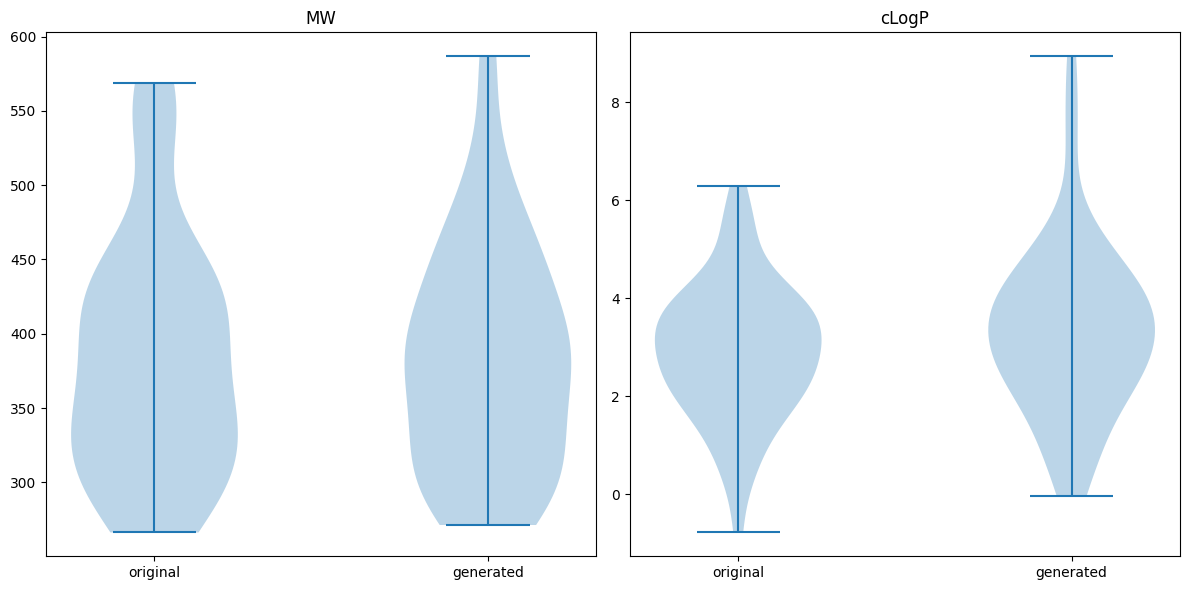

In [33]:
fig1 = plt.figure(figsize=(12, 6))

ax1 = fig1.add_subplot(1, 2, 1)
ax1.violinplot([props['MW']['original'], props['MW']['generated']])
ax1.set_xticks(ticks=[1, 2])
ax1.set_xticklabels(labels=['original', 'generated'])
ax1.set_title('MW')

ax2 = fig1.add_subplot(1, 2, 2)
ax2.violinplot([props['LogP']['original'], props['LogP']['generated']])
ax2.set_xticks(ticks=[1, 2])
ax2.set_xticklabels(labels=['original', 'generated'])
ax2.set_title('cLogP')

plt.tight_layout()

# plot violin with plotly MW generated vs original
fig2 = go.Figure()
fig2.add_trace(go.Violin(x=['original'] * len(props['MW']['original']), y=props['MW']['original'], name='original', box_visible=True, meanline_visible=True))
fig2.add_trace(go.Violin(x=['generated'] * len(props['MW']['generated']), y=props['MW']['generated'], name='generated', box_visible=True, meanline_visible=True))
fig2.update_layout(
    title="MW generated vs original",
    xaxis_title="",
    yaxis_title="",
    legend_title="",
)
fig2.show()

# plot violin with plotly LogP generated vs original
fig3 = go.Figure()
fig3.add_trace(go.Violin(x=['original'] * len(props['LogP']['original']), y=props['LogP']['original'], name='original', box_visible=True, meanline_visible=True))
fig3.add_trace(go.Violin(x=['generated'] * len(props['LogP']['generated']), y=props['LogP']['generated'], name='generated', box_visible=True, meanline_visible=True))
fig3.update_layout(
    title="LogP generated vs original",
    xaxis_title="",
    yaxis_title="",
    legend_title="",
)
fig3.show()
